In [1]:
import math
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import IPython.display as disp
from torch.utils.data import DataLoader
from torch import Tensor
from datasets import load_dataset, concatenate_datasets
from torchvision import transforms
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.ops.parametrizers import NonNegativeParametrizer

In [2]:
def analysis_1d(in_channels, out_channels, kernel_size=3, stride=2):
    return nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )

In [3]:
def synthesis_1d(in_channels, out_channels, kernel_size=3, stride=2):
    return nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )

In [4]:
class GDN_1d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        inverse: bool = False,
        beta_min: float = 1e-6,
        gamma_init: float = 0.1,
    ):
        super().__init__()

        beta_min = float(beta_min)
        gamma_init = float(gamma_init)
        self.inverse = bool(inverse)

        self.beta_reparam = NonNegativeParametrizer(minimum=beta_min)
        beta = torch.ones(in_channels)
        beta = self.beta_reparam.init(beta)
        self.beta = nn.Parameter(beta)

        self.gamma_reparam = NonNegativeParametrizer()
        gamma = gamma_init * torch.eye(in_channels)
        gamma = self.gamma_reparam.init(gamma)
        self.gamma = nn.Parameter(gamma)

    def forward(self, x: Tensor) -> Tensor:
        _, C, _ = x.size()

        beta = self.beta_reparam(self.beta)
        gamma = self.gamma_reparam(self.gamma)
        gamma = gamma.reshape(C, C, 1)
        norm = F.conv1d(x**2, gamma, beta)

        if self.inverse:
            norm = torch.sqrt(norm)
        else:
            norm = torch.rsqrt(norm)

        out = x * norm

        return out

In [5]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            analysis_1d(7, N),
            GDN_1d(N),
            analysis_1d(N, N),
            GDN_1d(N),
            analysis_1d(N, N),
        )

        self.decode = nn.Sequential(
            synthesis_1d(N, N),
            GDN_1d(N, inverse=True),
            synthesis_1d(N, N),
            GDN_1d(N, inverse=True),
            synthesis_1d(N, 7),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [6]:
def live_plot(rate, distortion):
    disp.clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(rate)
    plt.title('Rate')
    plt.xlabel('Iteration')
    plt.ylabel('Bits per Sample')
    
    plt.subplot(2, 1, 2)
    plt.plot(np.log(distortion))
    plt.title('Distortion')
    plt.xlabel('Iteration')
    plt.ylabel('log(Mean Square Error)')
    
    plt.tight_layout()
    plt.show()

In [7]:
%%time
dataset = load_dataset("danjacobellis/aria_ea_audio").with_format("torch")
dataset = concatenate_datasets([dataset[key] for key in dataset.keys()])

Generating loc3_script4_seq4_rec1 split:   0%|          | 0/84 [00:00<?, ? examples/s]

Generating loc4_script1_seq3_rec1 split:   0%|          | 0/17 [00:00<?, ? examples/s]

Generating loc4_script2_seq7_rec1 split:   0%|          | 0/20 [00:00<?, ? examples/s]

Generating loc5_script5_seq7_rec1 split:   0%|          | 0/42 [00:00<?, ? examples/s]

Generating loc3_script2_seq5_rec1 split:   0%|          | 0/21 [00:00<?, ? examples/s]

Generating loc3_script5_seq7_rec1 split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating loc2_script2_seq5_rec2 split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating loc1_script1_seq5_rec1 split:   0%|          | 0/19 [00:00<?, ? examples/s]

Generating loc3_script2_seq4_rec2 split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating loc3_script1_seq6_rec1 split:   0%|          | 0/15 [00:00<?, ? examples/s]

Generating loc4_script3_seq1_rec2 split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating loc2_script2_seq8_rec2 split:   0%|          | 0/15 [00:00<?, ? examples/s]

Generating loc2_script1_seq1_rec1 split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating loc4_script2_seq6_rec1 split:   0%|          | 0/7 [00:00<?, ? examples/s]

Generating loc1_script1_seq7_rec1 split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating loc2_script4_seq3_rec1 split:   0%|          | 0/36 [00:00<?, ? examples/s]

Generating loc3_script2_seq3_rec2 split:   0%|          | 0/30 [00:00<?, ? examples/s]

Generating loc3_script3_seq5_rec2 split:   0%|          | 0/30 [00:00<?, ? examples/s]

Generating loc1_script2_seq8_rec2 split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating loc1_script4_seq2_rec1 split:   0%|          | 0/42 [00:00<?, ? examples/s]

Generating loc3_script3_seq4_rec1 split:   0%|          | 0/45 [00:00<?, ? examples/s]

Generating loc3_script3_seq2_rec2 split:   0%|          | 0/27 [00:00<?, ? examples/s]

Generating loc1_script1_seq3_rec1 split:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating loc3_script3_seq1_rec1 split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating loc1_script2_seq3_rec2 split:   0%|          | 0/31 [00:00<?, ? examples/s]

Generating loc1_script2_seq7_rec1 split:   0%|          | 0/42 [00:00<?, ? examples/s]

Generating loc2_script2_seq4_rec1 split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating loc1_script2_seq8_rec1 split:   0%|          | 0/15 [00:00<?, ? examples/s]

Generating loc2_script2_seq1_rec2 split:   0%|          | 0/21 [00:00<?, ? examples/s]

Generating loc5_script5_seq1_rec1 split:   0%|          | 0/20 [00:00<?, ? examples/s]

Generating loc2_script5_seq4_rec1 split:   0%|          | 0/4 [00:00<?, ? examples/s]

Generating loc2_script2_seq2_rec1 split:   0%|          | 0/17 [00:00<?, ? examples/s]

Generating loc4_script5_seq3_rec1 split:   0%|          | 0/25 [00:00<?, ? examples/s]

Generating loc2_script5_seq3_rec1 split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating loc1_script2_seq4_rec2 split:   0%|          | 0/33 [00:00<?, ? examples/s]

Generating loc2_script2_seq2_rec2 split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating loc1_script4_seq4_rec1 split:   0%|          | 0/74 [00:00<?, ? examples/s]

Generating loc2_script1_seq2_rec1 split:   0%|          | 0/25 [00:00<?, ? examples/s]

Generating loc3_script2_seq3_rec1 split:   0%|          | 0/30 [00:00<?, ? examples/s]

Generating loc2_script3_seq4_rec2 split:   0%|          | 0/40 [00:00<?, ? examples/s]

Generating loc3_script2_seq1_rec2 split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating loc2_script2_seq5_rec1 split:   0%|          | 0/40 [00:00<?, ? examples/s]

Generating loc1_script3_seq5_rec1 split:   0%|          | 0/57 [00:00<?, ? examples/s]

Generating loc3_script5_seq5_rec1 split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating loc2_script5_seq7_rec1 split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating loc2_script5_seq5_rec1 split:   0%|          | 0/27 [00:00<?, ? examples/s]

Generating loc4_script3_seq4_rec1 split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating loc5_script4_seq4_rec1 split:   0%|          | 0/49 [00:00<?, ? examples/s]

Generating loc4_script2_seq1_rec2 split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating loc3_script4_seq5_rec1 split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating loc4_script2_seq3_rec2 split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating loc2_script2_seq3_rec2 split:   0%|          | 0/12 [00:00<?, ? examples/s]

Generating loc1_script2_seq6_rec2 split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating loc1_script5_seq3_rec1 split:   0%|          | 0/20 [00:00<?, ? examples/s]

Generating loc3_script2_seq7_rec2 split:   0%|          | 0/15 [00:00<?, ? examples/s]

Generating loc2_script1_seq5_rec1 split:   0%|          | 0/25 [00:00<?, ? examples/s]

Generating loc1_script5_seq6_rec1 split:   0%|          | 0/30 [00:00<?, ? examples/s]

Generating loc3_script2_seq5_rec2 split:   0%|          | 0/21 [00:00<?, ? examples/s]

Generating loc3_script1_seq7_rec1 split:   0%|          | 0/17 [00:00<?, ? examples/s]

Generating loc1_script2_seq6_rec1 split:   0%|          | 0/20 [00:00<?, ? examples/s]

Generating loc1_script5_seq2_rec1 split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating loc5_script4_seq6_rec1 split:   0%|          | 0/34 [00:00<?, ? examples/s]

Generating loc2_script5_seq2_rec1 split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating loc4_script2_seq2_rec1 split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating loc2_script4_seq7_rec1 split:   0%|          | 0/36 [00:00<?, ? examples/s]

Generating loc4_script1_seq6_rec1 split:   0%|          | 0/19 [00:00<?, ? examples/s]

Generating loc2_script5_seq6_rec1 split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating loc3_script4_seq7_rec1 split:   0%|          | 0/27 [00:00<?, ? examples/s]

Generating loc4_script2_seq4_rec1 split:   0%|          | 0/20 [00:00<?, ? examples/s]

Generating loc5_script4_seq5_rec1 split:   0%|          | 0/82 [00:00<?, ? examples/s]

Generating loc3_script2_seq4_rec1 split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating loc1_script1_seq6_rec1 split:   0%|          | 0/25 [00:00<?, ? examples/s]

Generating loc2_script1_seq4_rec1 split:   0%|          | 0/47 [00:00<?, ? examples/s]

Generating loc1_script2_seq1_rec1 split:   0%|          | 0/19 [00:00<?, ? examples/s]

Generating loc1_script2_seq4_rec1 split:   0%|          | 0/34 [00:00<?, ? examples/s]

Generating loc4_script1_seq5_rec1 split:   0%|          | 0/24 [00:00<?, ? examples/s]

Generating loc3_script4_seq2_rec1 split:   0%|          | 0/49 [00:00<?, ? examples/s]

Generating loc3_script3_seq1_rec2 split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating loc5_script4_seq1_rec1 split:   0%|          | 0/27 [00:00<?, ? examples/s]

Generating loc4_script4_seq2_rec1 split:   0%|          | 0/15 [00:00<?, ? examples/s]

Generating loc1_script4_seq3_rec1 split:   0%|          | 0/39 [00:00<?, ? examples/s]

Generating loc4_script5_seq1_rec1 split:   0%|          | 0/8 [00:00<?, ? examples/s]

Generating loc2_script1_seq3_rec1 split:   0%|          | 0/34 [00:00<?, ? examples/s]

Generating loc2_script3_seq4_rec1 split:   0%|          | 0/40 [00:00<?, ? examples/s]

Generating loc2_script2_seq4_rec2 split:   0%|          | 0/15 [00:00<?, ? examples/s]

Generating loc5_script5_seq4_rec1 split:   0%|          | 0/30 [00:00<?, ? examples/s]

Generating loc2_script4_seq5_rec1 split:   0%|          | 0/39 [00:00<?, ? examples/s]

Generating loc2_script4_seq4_rec1 split:   0%|          | 0/160 [00:00<?, ? examples/s]

Generating loc3_script1_seq1_rec1 split:   0%|          | 0/24 [00:00<?, ? examples/s]

Generating loc2_script3_seq2_rec1 split:   0%|          | 0/13 [00:00<?, ? examples/s]

Generating loc2_script1_seq6_rec1 split:   0%|          | 0/31 [00:00<?, ? examples/s]

Generating loc5_script4_seq3_rec1 split:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating loc3_script1_seq2_rec1 split:   0%|          | 0/36 [00:00<?, ? examples/s]

Generating loc3_script2_seq1_rec1 split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating loc2_script3_seq5_rec2 split:   0%|          | 0/36 [00:00<?, ? examples/s]

Generating loc3_script1_seq5_rec1 split:   0%|          | 0/28 [00:00<?, ? examples/s]

Generating loc1_script2_seq3_rec1 split:   0%|          | 0/31 [00:00<?, ? examples/s]

Generating loc3_script3_seq4_rec2 split:   0%|          | 0/44 [00:00<?, ? examples/s]

Generating loc2_script3_seq3_rec2 split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating loc2_script1_seq7_rec1 split:   0%|          | 0/17 [00:00<?, ? examples/s]

Generating loc4_script5_seq7_rec1 split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating loc2_script2_seq6_rec2 split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating loc3_script2_seq2_rec1 split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating loc1_script3_seq2_rec1 split:   0%|          | 0/13 [00:00<?, ? examples/s]

Generating loc5_script4_seq2_rec1 split:   0%|          | 0/43 [00:00<?, ? examples/s]

Generating loc4_script3_seq3_rec1 split:   0%|          | 0/73 [00:00<?, ? examples/s]

Generating loc2_script2_seq8_rec1 split:   0%|          | 0/15 [00:00<?, ? examples/s]

Generating loc1_script4_seq5_rec1 split:   0%|          | 0/40 [00:00<?, ? examples/s]

Generating loc3_script3_seq2_rec1 split:   0%|          | 0/27 [00:00<?, ? examples/s]

Generating loc2_script2_seq6_rec1 split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating loc2_script3_seq2_rec2 split:   0%|          | 0/13 [00:00<?, ? examples/s]

Generating loc2_script3_seq5_rec1 split:   0%|          | 0/38 [00:00<?, ? examples/s]

Generating loc2_script3_seq1_rec1 split:   0%|          | 0/5 [00:00<?, ? examples/s]

Generating loc3_script5_seq6_rec1 split:   0%|          | 0/25 [00:00<?, ? examples/s]

Generating loc3_script3_seq5_rec1 split:   0%|          | 0/30 [00:00<?, ? examples/s]

Generating loc1_script5_seq5_rec1 split:   0%|          | 0/47 [00:00<?, ? examples/s]

Generating loc5_script5_seq3_rec1 split:   0%|          | 0/33 [00:00<?, ? examples/s]

Generating loc3_script5_seq4_rec1 split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating loc2_script3_seq3_rec1 split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating loc3_script5_seq3_rec1 split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating loc3_script2_seq7_rec1 split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating loc1_script1_seq1_rec1 split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating loc3_script5_seq2_rec1 split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating loc3_script1_seq4_rec1 split:   0%|          | 0/68 [00:00<?, ? examples/s]

Generating loc4_script3_seq2_rec2 split:   0%|          | 0/9 [00:00<?, ? examples/s]

Generating loc2_script3_seq1_rec2 split:   0%|          | 0/5 [00:00<?, ? examples/s]

Generating loc4_script1_seq1_rec1 split:   0%|          | 0/26 [00:00<?, ? examples/s]

Generating loc5_script5_seq6_rec1 split:   0%|          | 0/69 [00:00<?, ? examples/s]

Generating loc3_script5_seq1_rec1 split:   0%|          | 0/13 [00:00<?, ? examples/s]

Generating loc1_script3_seq1_rec1 split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating loc2_script2_seq3_rec1 split:   0%|          | 0/12 [00:00<?, ? examples/s]

Generating loc5_script5_seq5_rec1 split:   0%|          | 0/70 [00:00<?, ? examples/s]

Generating loc3_script1_seq3_rec1 split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating loc1_script5_seq1_rec1 split:   0%|          | 0/7 [00:00<?, ? examples/s]

Generating loc3_script4_seq3_rec1 split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating loc2_script2_seq1_rec1 split:   0%|          | 0/21 [00:00<?, ? examples/s]

Generating loc2_script5_seq1_rec1 split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating loc1_script2_seq1_rec2 split:   0%|          | 0/19 [00:00<?, ? examples/s]

Generating loc5_script5_seq2_rec1 split:   0%|          | 0/26 [00:00<?, ? examples/s]

Generating loc4_script2_seq8_rec2 split:   0%|          | 0/9 [00:00<?, ? examples/s]

CPU times: user 4min 49s, sys: 7min 45s, total: 12min 35s
Wall time: 1h 3min 22s


In [8]:
def preprocess(sample):
    x = sample['audio'].to(torch.float)
    xr = x.transpose(0, 1).unsqueeze(0)
    num_channels = xr.size(1)
    kernel_size = 33
    kernel = torch.ones(num_channels, 1, kernel_size) / kernel_size
    smoothed_signal = F.conv1d(xr, kernel, padding='same', groups=num_channels)
    smoothed_signal = smoothed_signal.squeeze(0).transpose(0, 1)
    filtered_signal = x - smoothed_signal
    scaled_signal = (filtered_signal/(2**23)).tanh()
    sample['audio'] = scaled_signal
    return sample

In [9]:
%%time
preprocessed_dataset = dataset.map(preprocess, writer_batch_size=400)

Map:   0%|          | 0/4095 [00:00<?, ? examples/s]

CPU times: user 1h 24min 24s, sys: 11min 7s, total: 1h 35min 32s
Wall time: 1h 45min 49s


In [10]:
net = RateDistortionAutoEncoder().to("cuda")
parameters = set(p for n, p in net.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in net.named_parameters() if n.endswith(".quantiles"))
optimizer = optim.AdamW(parameters, lr=1e-4)
aux_optimizer = optim.AdamW(aux_parameters, lr=1e-3)
λ = 1e-5

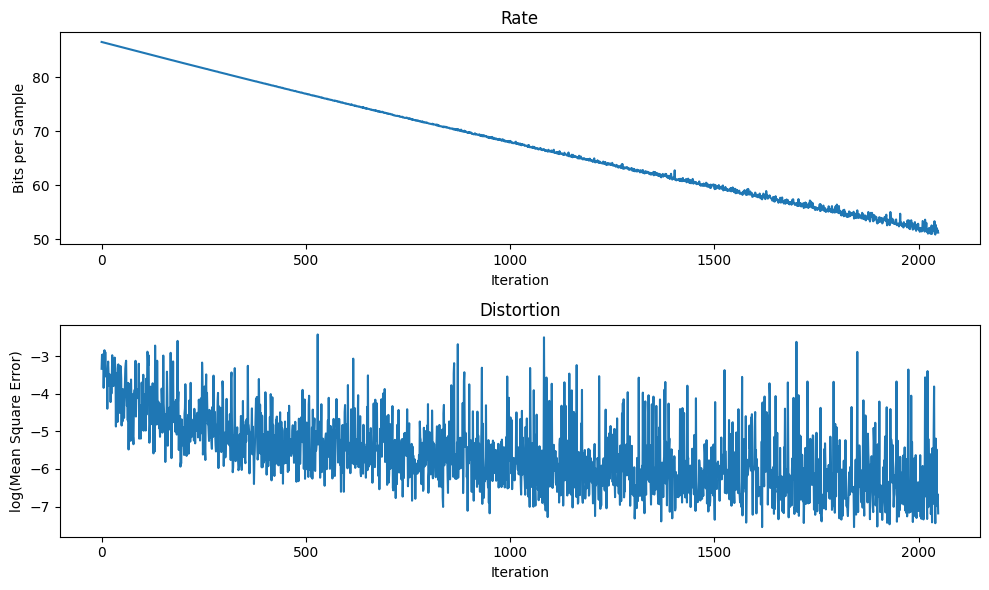

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
%time
rate = np.array([])
distortion = np.array([])
for i_epoch in range(20):
    dataloader = DataLoader(preprocessed_dataset, batch_size=6, shuffle=True)
    for i,batch in enumerate(dataloader):
        print(i)
        optimizer.zero_grad()
        aux_optimizer.zero_grad()
    
        x = batch['audio'].permute(0,2,1).to("cuda")
        x = x.to(torch.float)
        
        x_hat, y_likelihoods = net(x)
        
        # bitrate of the quantized latent
        N, _, L = x.size()
        num_samples = N * L
        bps_loss = torch.log(y_likelihoods).sum() / (-math.log(2) * num_samples)
        rate = np.append(rate,bps_loss.detach().cpu().numpy())
        
        # mean square error
        mse_loss = F.mse_loss(x, x_hat)
        distortion = np.append(distortion,mse_loss.detach().cpu().numpy())
        
        # final loss term
        loss = mse_loss + λ * bps_loss
        
        loss.backward()
        optimizer.step()
        
        aux_loss = net.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()

    torch.save({
            'epoch': i,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'aux_optimizer_state_dict': aux_optimizer.state_dict(),
            'loss': loss,
        }, f"checkpoint{i}.pth")
    live_plot(rate,distortion)
    np.save('rate',rate)
    np.save('distortion',distortion)